In [2]:
import torch
import torch.nn as nn
import numpy as np
import normflows as nf
import numpy as np

import Train

from matplotlib import pyplot as plt
from tqdm import tqdm
from Base import DirichletProcessMixture, DPGM, DirichletProcessMixture_Gumbel, TProductDistribution, GaussianDistribution
from HeavyTarget import AsymmetricStudentT, MixtureTarget, MultStudentT, GaussianDistribution, SymmetricParetoMixture, NormalInvGammaPosterior

import torch.optim as optim
from torch.distributions import MultivariateNormal, Beta, kl_divergence


In [3]:
#set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [4]:
# Gaussian Bimodal Target
import torch
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

# (1) Target 정의
class Target:
    def __init__(self):
        self.weights = torch.tensor([0.7, 0.3])
        self.means   = [torch.tensor([4.0]), torch.tensor([-1.0])]
        self.covs    = [torch.eye(1), torch.eye(1)]
        self.comps   = [
            MultivariateNormal(loc=m, covariance_matrix=S)
            for m, S in zip(self.means, self.covs)
        ]
    def log_prob(self, x):
        # x: [N,1]
        log_ps = torch.stack([comp.log_prob(x) for comp in self.comps], dim=1)
        log_ps = log_ps + torch.log(self.weights)      # [N,2]
        return torch.logsumexp(log_ps, dim=1)          # [N]

    def sample(self, num_samples=1):
        """
        num_samples개의 샘플을 mixture에서 뽑아 [num_samples, 1] 크기의 Tensor로 반환.
        """
        # (1) 컴포넌트 인덱스 샘플링: [num_samples]
        idx = torch.multinomial(self.weights, num_samples, replacement=True)

        # (2) 결과 저장용 Tensor 생성
        out = torch.zeros(num_samples, self.means[0].shape[0])

        # (3) 각 컴포넌트별 필요한 수 만큼 샘플링하여 채우기
        for i, comp in enumerate(self.comps):
            mask = (idx == i)
            count = mask.sum().item()
            if count > 0:
                # comp.sample((count,)) → [count, 1]
                out[mask] = comp.sample((count,))

        return out

# (2) Variational family 불러오기
# from your_module import DirichletProcessMixture_Gumbel
# 여기서는 이미 정의된 DirichletProcessMixture_Gumbel 클래스를 사용한다고 가정

# (3) 인스턴스화
#target = Target()  

In [5]:
# set seed.
torch.manual_seed(0)
np.random.seed(0)

dimension = 2
#base = nf.distributions.GaussianMixture(n_modes=2, dim=dimension, loc=[[3],[-3]], weights=[0.1, 0.9])
#base = DPGM(shape=dimension, T=2)
base = DirichletProcessMixture(shape=dimension, T=30)

Using log_prob for density estimation


/Users/hanseungsu/Desktop/intern/장 원 교수님/pytorch/Gaussian Student-T Mixture/Train.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lp = dist_fn(torch.tensor(grid_points, dtype=torch.float32))


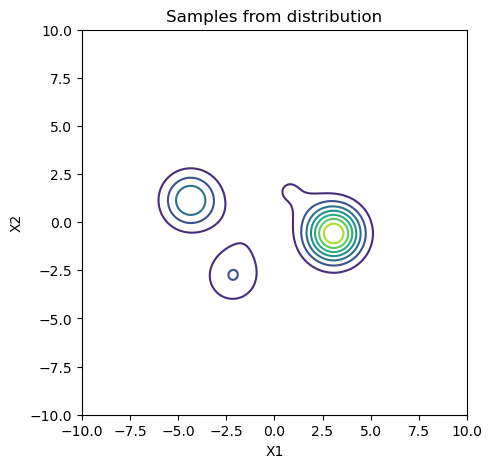

In [6]:
Train.plot_samples(base, vmin=-10, vmax=10, num_samples=10000, two_d=True, contour=True)

In [7]:
#Train.print_model_parameters(base)

In [8]:
#target = MultStudentT(df=2, mean=[0.0])

#target = SymmetricParetoMixture(n_mode=1, dim = 1, alpha=2.0)

target1 = AsymmetricStudentT(df=[2,2], mean=[3.0,3.0])
target2 = AsymmetricStudentT(df=[4,4], mean=[-3.0, -3.0])
target = MixtureTarget(target1, target2, weight=[0.4, 0.6])



In [9]:
'''import torch
from torch.distributions import Normal, Gamma

# (1) 가상 데이터 생성
torch.manual_seed(0)
mu_true, sigma2_true = 2.0, 3.0
N = 100
data = Normal(mu_true, sigma2_true**0.5).sample((N,))        # [N]

# (2) Prior 하이퍼파라미터 설정
mu0, kappa0 = 0.0, 1.0
alpha0, beta0 = 2.0, 2.0

# (3) 후험 하이퍼파라미터 계산
n    = data.shape[0]
xbar = data.mean()
kappa_n = kappa0 + n
mu_n    = (kappa0*mu0 + n*xbar) / kappa_n
alpha_n = alpha0 + n/2
beta_n  = beta0 \
          + 0.5 * ((data - xbar)**2).sum() \
          + (kappa0 * n) / (2 * kappa_n) * (xbar - mu0)**2

target = NormalInvGammaPosterior(mu_n, kappa_n, alpha_n, beta_n)
'''

'import torch\nfrom torch.distributions import Normal, Gamma\n\n# (1) 가상 데이터 생성\ntorch.manual_seed(0)\nmu_true, sigma2_true = 2.0, 3.0\nN = 100\ndata = Normal(mu_true, sigma2_true**0.5).sample((N,))        # [N]\n\n# (2) Prior 하이퍼파라미터 설정\nmu0, kappa0 = 0.0, 1.0\nalpha0, beta0 = 2.0, 2.0\n\n# (3) 후험 하이퍼파라미터 계산\nn    = data.shape[0]\nxbar = data.mean()\nkappa_n = kappa0 + n\nmu_n    = (kappa0*mu0 + n*xbar) / kappa_n\nalpha_n = alpha0 + n/2\nbeta_n  = beta0           + 0.5 * ((data - xbar)**2).sum()           + (kappa0 * n) / (2 * kappa_n) * (xbar - mu0)**2\n\ntarget = NormalInvGammaPosterior(mu_n, kappa_n, alpha_n, beta_n)\n'

In [10]:
#Train.estimate_tail_indices_t(mean=[3.0, 3.0], scale=[1.0, 1.0], df=2, global_mean=[0.0, 0.0],target = target, num_samples=3000, k=2990)

Using log_prob for density estimation


/Users/hanseungsu/Desktop/intern/장 원 교수님/pytorch/Gaussian Student-T Mixture/Train.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lp = dist_fn(torch.tensor(grid_points, dtype=torch.float32))


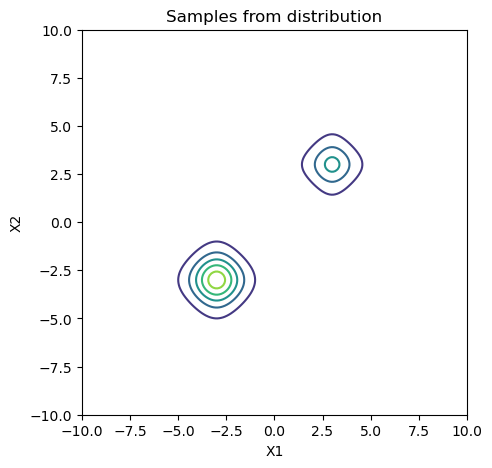

In [11]:
Train.plot_samples(target, vmin=-10, vmax=10, num_samples=10000, two_d=True, kde=True, contour=True)

In [12]:
'''
optimizer = optim.Adam(q0.parameters(), lr=5e-3, weight_decay=1e-5)
num_samples = 4096
max_iter    = 8000
loss_hist = []

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # (i) θ, log q(θ|c)+log q(c|V) pathwise 한 번만 샘플
    theta, log_q_tc = q0.forward(num_samples)   # [N,1], [N]

    # (ii) target log-prob (up to const)
    log_p = target.log_prob(theta)              # [N]

    # (iii) analytic KL(q(V)||p(V)) — Beta(a,b) vs Beta(1,α)
    a     = torch.exp(q0.log_a)                 # [T-1]
    b     = torch.exp(q0.log_b)
    alpha = torch.exp(q0.log_alpha)             # if you want general prior Beta(1,α)
    prior = Beta(torch.ones_like(a), alpha)     # or Beta(1,1) if α=1
    post  = Beta(a, b)
    kl_V  = kl_divergence(post, prior).sum()    # scalar

    # (iv) joint-KL loss = E_q[log q(θ,c,V)] − E_q[log p(θ)]
    #      where log q(θ,c|V) = log_q_tc, and log q(V) is in kl_V
    loss = log_q_tc.mean() + kl_V - log_p.mean()

    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())
    if it % 300 == 0:
        print(f"Iter {it:4d}  loss = {loss.item(): .4f}")
'''


'\noptimizer = optim.Adam(q0.parameters(), lr=5e-3, weight_decay=1e-5)\nnum_samples = 4096\nmax_iter    = 8000\nloss_hist = []\n\nfor it in tqdm(range(max_iter)):\n    optimizer.zero_grad()\n\n    # (i) θ, log q(θ|c)+log q(c|V) pathwise 한 번만 샘플\n    theta, log_q_tc = q0.forward(num_samples)   # [N,1], [N]\n\n    # (ii) target log-prob (up to const)\n    log_p = target.log_prob(theta)              # [N]\n\n    # (iii) analytic KL(q(V)||p(V)) — Beta(a,b) vs Beta(1,α)\n    a     = torch.exp(q0.log_a)                 # [T-1]\n    b     = torch.exp(q0.log_b)\n    alpha = torch.exp(q0.log_alpha)             # if you want general prior Beta(1,α)\n    prior = Beta(torch.ones_like(a), alpha)     # or Beta(1,1) if α=1\n    post  = Beta(a, b)\n    kl_V  = kl_divergence(post, prior).sum()    # scalar\n\n    # (iv) joint-KL loss = E_q[log q(θ,c,V)] − E_q[log p(θ)]\n    #      where log q(θ,c|V) = log_q_tc, and log q(V) is in kl_V\n    loss = log_q_tc.mean() + kl_V - log_p.mean()\n\n    loss.backwar

In [13]:
'''
import torch
import torch.nn.functional as F
from torch.distributions import Beta
from tqdm import tqdm
import numpy as np

# 1) 정의: 비모수 변분분포
q0 = base
# target 은 up-to-constant log 밀도를 반환하는 객체
# class Target:
#     def log_prob(self, theta): ... 

# 2) 옵티마이저
optimizer = torch.optim.Adam(q0.parameters(), lr=5e-3, weight_decay=1e-5)

loss_hist = []

# 3) 학습 루프
for it in tqdm(range(4000)):
    optimizer.zero_grad()
    # (i) 재파라미터 표본: θ, 그리고 log q(θ|mode)+log q(mode|V)
    theta, log_q_tc = q0.forward(num_samples=1024)
    # theta: [1024, 1], log_q_tc: [1024]

    # (ii) 표적 사후(log p) 계산
    log_p = target.log_prob(theta).view(-1)       # [1024]

    # (iii) 분석적 E_q[log q(V)] 항
    a = torch.exp(q0.log_a)                       # [T-1]
    b = torch.exp(q0.log_b)
    # E_q[log Beta(V_k; a_k,b_k)] = log B(a,b)⁻¹ + (a-1)ψ(a) + (b-1)ψ(b) - (a+b-2)ψ(a+b)
    term  = torch.lgamma(a+b) - torch.lgamma(a) - torch.lgamma(b)
    term += (a-1)*(torch.digamma(a)) + (b-1)*(torch.digamma(b))
    term -= (a+b-2)*torch.digamma(a+b)
    log_qV = term.sum()                           # scalar

    # (iv) 전체 변분 로그밀도
    #     log q(θ,c,V) = [log_q_tc] + [log_qV]
    #               (pathwise)   + (analytic)
    log_q_total = log_q_tc + log_qV              # broadcast, shape [1024]

    # (v) reverse-KL loss = E_q[log q] - E_q[log p]
    loss = torch.mean(log_q_total) - torch.mean(log_p)

    # backprop & step
    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())
    if it % 300 == 0:
        print(f"Iter {it} → loss {loss.item():.3f}")

# 결과: q0.log_a, q0.log_b, q0.means, q0.log_scale 등에 gradient 가 흘러 학습됨
# 히스토그램 등으로 최종 θ 샘플과 target 분포를 비교해 보세요.
'''


'\nimport torch\nimport torch.nn.functional as F\nfrom torch.distributions import Beta\nfrom tqdm import tqdm\nimport numpy as np\n\n# 1) 정의: 비모수 변분분포\nq0 = base\n# target 은 up-to-constant log 밀도를 반환하는 객체\n# class Target:\n#     def log_prob(self, theta): ... \n\n# 2) 옵티마이저\noptimizer = torch.optim.Adam(q0.parameters(), lr=5e-3, weight_decay=1e-5)\n\nloss_hist = []\n\n# 3) 학습 루프\nfor it in tqdm(range(4000)):\n    optimizer.zero_grad()\n    # (i) 재파라미터 표본: θ, 그리고 log q(θ|mode)+log q(mode|V)\n    theta, log_q_tc = q0.forward(num_samples=1024)\n    # theta: [1024, 1], log_q_tc: [1024]\n\n    # (ii) 표적 사후(log p) 계산\n    log_p = target.log_prob(theta).view(-1)       # [1024]\n\n    # (iii) 분석적 E_q[log q(V)] 항\n    a = torch.exp(q0.log_a)                       # [T-1]\n    b = torch.exp(q0.log_b)\n    # E_q[log Beta(V_k; a_k,b_k)] = log B(a,b)⁻¹ + (a-1)ψ(a) + (b-1)ψ(b) - (a+b-2)ψ(a+b)\n    term  = torch.lgamma(a+b) - torch.lgamma(a) - torch.lgamma(b)\n    term += (a-1)*(torch.digamma(a)) + (

In [14]:
K = 2
latent_size = dimension
hidden_units = 64
hidden_layers = 3

flows = []

for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    #flows += [nf.flows.LULinearPermute(latent_size, identity_init=True)]

model = nf.NormalizingFlow(base, flows, p=target)
model = model.to(torch.float32)

### General training(without tail adjustment)

In [15]:
'''
max_iter = 4000
lr = 5e-3
num_samples = 2**10
show_iter = 1000
weight_decay = 1e-5
freeze_flow =True # freeze flow parameters
freeze_ratio = 0.2 # do not update flow parameters. 

loss_hist = np.array([])

# Freeze the flow parameters
for param in model.flows.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = model.reverse_kld(num_samples)
    if it == int(max_iter * freeze_ratio):
        if freeze_flow:
            for param in model.flows.parameters():
                param.requires_grad = True
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward(retain_graph=True)
        optimizer.step()
        if it % show_iter == 0:
            print(f"Iteration {it}, loss: {loss.item()}")
            Train.plot_samples(model, num_samples=1000, two_d=True, min=-10, max=10)
        
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
'''

'\nmax_iter = 4000\nlr = 5e-3\nnum_samples = 2**10\nshow_iter = 1000\nweight_decay = 1e-5\nfreeze_flow =True # freeze flow parameters\nfreeze_ratio = 0.2 # do not update flow parameters. \n\nloss_hist = np.array([])\n\n# Freeze the flow parameters\nfor param in model.flows.parameters():\n    param.requires_grad = False\n    \noptimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)\n\nfor it in tqdm(range(max_iter)):\n    optimizer.zero_grad()\n    loss = model.reverse_kld(num_samples)\n    if it == int(max_iter * freeze_ratio):\n        if freeze_flow:\n            for param in model.flows.parameters():\n                param.requires_grad = True\n    # Do backprop and optimizer step\n    if ~(torch.isnan(loss) | torch.isinf(loss)):\n        loss.backward(retain_graph=True)\n        optimizer.step()\n        if it % show_iter == 0:\n            print(f"Iteration {it}, loss: {loss.item()}")\n            Train.plot_samples(model, num_samples=1000, two_d=True, m

 12%|█▏        | 498/4000 [00:07<00:49, 70.42it/s]/Users/hanseungsu/Desktop/intern/장 원 교수님/pytorch/Gaussian Student-T Mixture/Train.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lp = dist_fn(torch.tensor(grid_points, dtype=torch.float32))


Using log_prob for density estimation


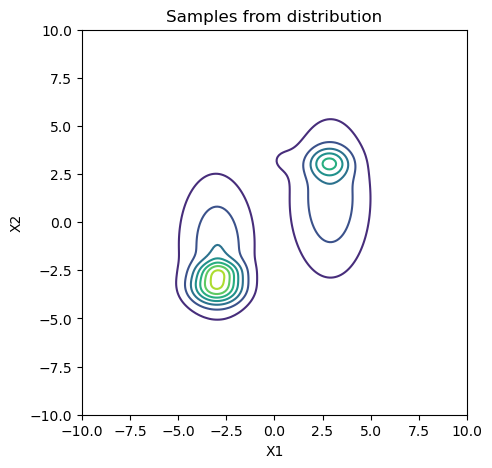

 25%|██▍       | 999/4000 [00:15<00:43, 69.00it/s]

Using log_prob for density estimation


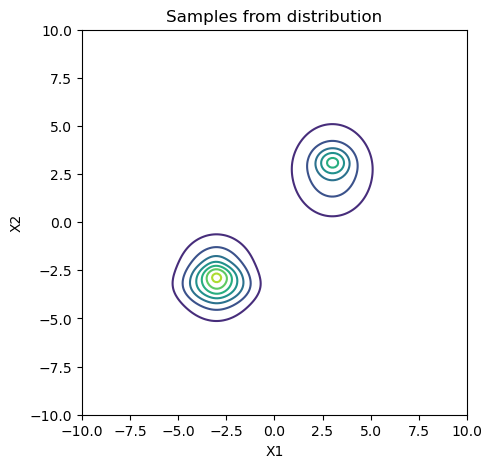

 37%|███▋      | 1495/4000 [00:23<00:36, 67.80it/s]

Using log_prob for density estimation


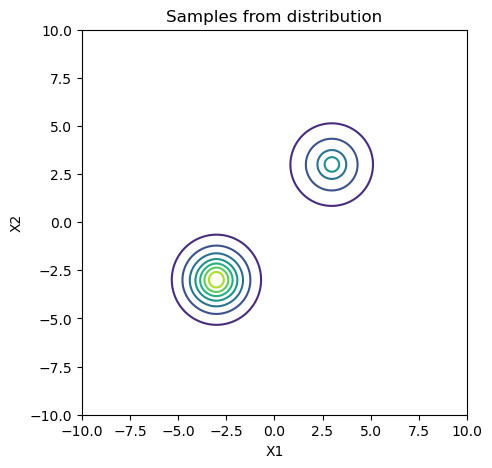

 40%|███▉      | 1594/4000 [00:24<00:35, 67.20it/s]/Users/hanseungsu/Desktop/intern/장 원 교수님/pytorch/Gaussian Student-T Mixture/Train.py:284: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_tensor = torch.tensor(dfs, dtype=torch.float32, device=device)
 40%|████      | 1607/4000 [00:24<00:44, 53.64it/s]

tensor([1.9934, 1.9929])
tensor([3.5568, 3.5598])
tensor([3.5048, 3.6326])
tensor([1.8494, 1.8211])
tensor([3.6065, 3.7948])
tensor([3.4743, 3.6500])
tensor([2.0387, 1.9657])
tensor([3.5653, 3.9736])
tensor([1.6588, 2.0504])
tensor([2.6585, 2.9766])
tensor([2.1586, 2.0070])
tensor([2.1667, 2.1498])
tensor([2.4048, 2.1484])
tensor([3.8910, 3.6131])
tensor([2.4971, 1.9294])
tensor([2.7500, 1.7688])
tensor([2.5082, 2.3453])
tensor([1.7761, 2.3877])
tensor([2.7476, 2.6224])
tensor([2.7861, 2.5035])
tensor([2.4347, 2.7406])
tensor([2.5547, 2.5497])
tensor([2.7585, 2.7986])
tensor([2.5803, 2.6019])
tensor([2.6535, 2.4045])
tensor([2.6398, 2.5174])
tensor([2.8475, 2.4491])
tensor([2.7595, 2.7876])
tensor([2.8858, 2.8985])
tensor([2.7763, 2.9237])


 50%|████▉     | 1998/4000 [00:31<00:33, 60.26it/s]

Using log_prob for density estimation


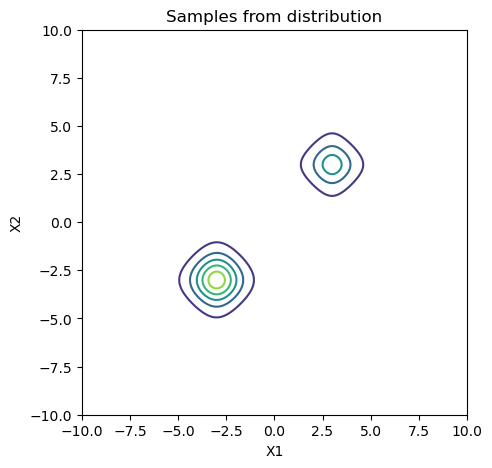

 62%|██████▏   | 2499/4000 [00:39<00:26, 55.87it/s]

Using log_prob for density estimation


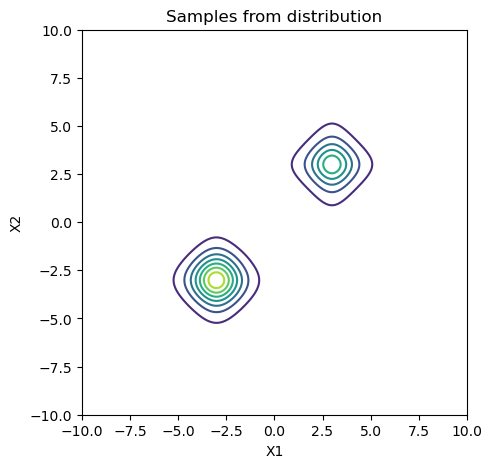

 75%|███████▍  | 2994/4000 [00:48<00:17, 58.72it/s]

Using log_prob for density estimation


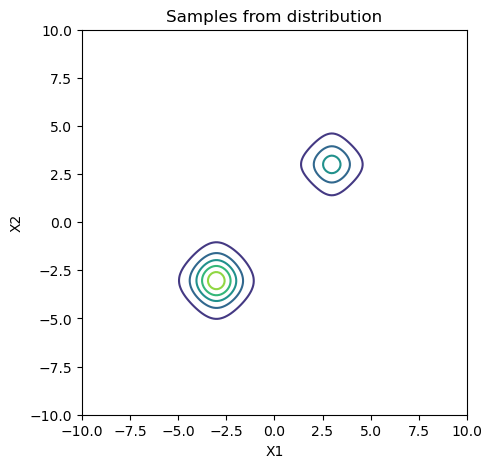

 87%|████████▋ | 3494/4000 [00:58<00:09, 52.03it/s]

Using log_prob for density estimation


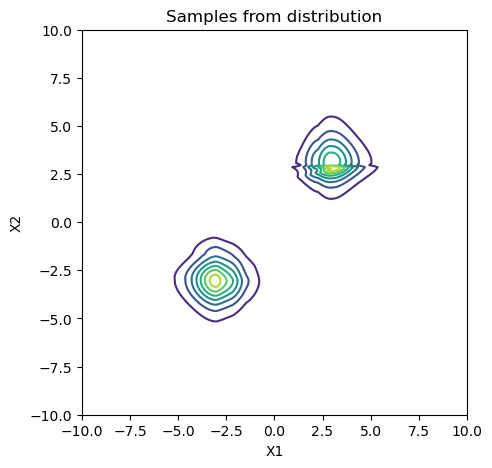

100%|█████████▉| 3995/4000 [01:07<00:00, 53.11it/s]

Using log_prob for density estimation


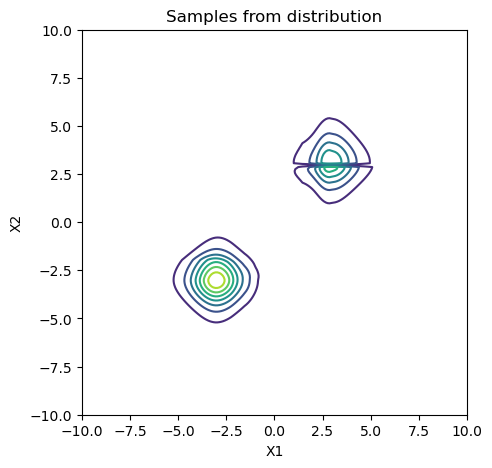

100%|██████████| 4000/4000 [01:08<00:00, 58.70it/s]

alpha_hist is empty, no data to plot.


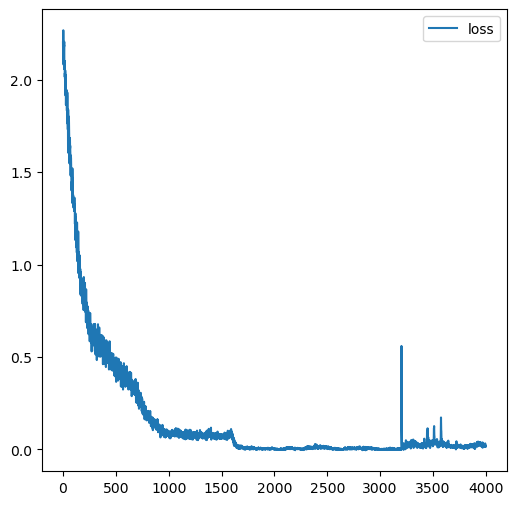

In [16]:
Train.TrainModel(model,
                 dimension=2,
                 max_iter=4000,
                 lr=5e-3,
                 num_samples=2**10,
                 show_iter=500,
                 weight_decay=1e-5,
                 freeze_flow=True,
                 freeze_ratio=0.8
                 )

Using log_prob for density estimation


/Users/hanseungsu/Desktop/intern/장 원 교수님/pytorch/Gaussian Student-T Mixture/Train.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lp = dist_fn(torch.tensor(grid_points, dtype=torch.float32))


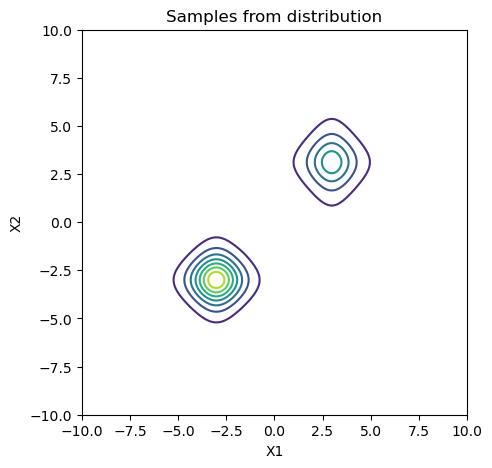

In [17]:
Train.plot_samples(model.q0, num_samples=10000, two_d=True, vmin=-10, vmax=10, contour=True)

In [18]:
Train.print_model_parameters(model.q0)

--- stick-breaking params ---
  a: [0.9258, 6.7312, 1.1792, 1.1142, 1.0545, …]
  b: [1.0801, 0.1486, 0.8480, 0.8975, 0.9483, …]
  pi (expected): [0.4615, 0.5268, 0.0068, 0.0027, 0.0011, …]

--- component #0 (TProductDistribution) ---
  mean: [2.9827, 3.1170]
  scale: [1.0388, 1.1828]
  df: [1.9934, 1.9929]

--- component #1 (TProductDistribution) ---
  mean: [-3.0225, -2.9972]
  scale: [0.9664, 0.9614]
  df: [3.5568, 3.5598]

--- component #2 (TProductDistribution) ---
  mean: [-1.7597, -3.2303]
  scale: [1.0728, 1.1834]
  df: [3.5048, 3.6326]

--- component #3 (TProductDistribution) ---
  mean: [2.5617, 3.1339]
  scale: [0.7490, 0.6615]
  df: [1.8494, 1.8211]

--- component #4 (TProductDistribution) ---
  mean: [-2.0608, -1.6103]
  scale: [1.1300, 0.4169]
  df: [3.6065, 3.7948]

--- component #5 (TProductDistribution) ---
  mean: [-1.5041, -1.6936]
  scale: [0.4257, 0.9283]
  df: [3.4743, 3.6500]

--- component #6 (TProductDistribution) ---
  mean: [0.0058, 1.8174]
  scale: [2.6728, 0

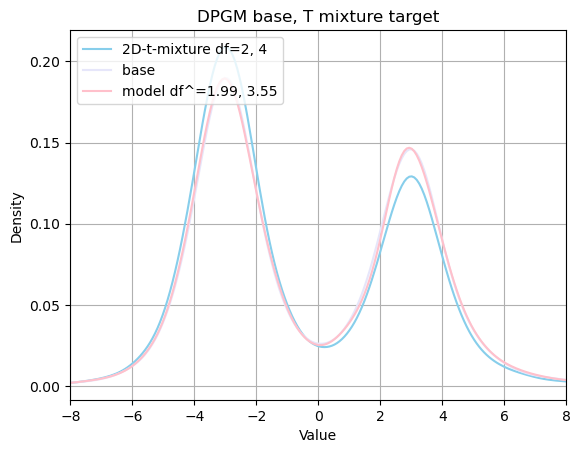

In [20]:
from scipy.stats import gaussian_kde
# target 에서 샘플을 뽑을 수 있는 경우에만..
np.random.seed(1)
torch.manual_seed(1)

marginal = 1
s1 = target.sample(num_samples=100000).cpu().detach().numpy()[:, marginal-1]
s2 = model.q0.forward(100000)[0].cpu().detach().numpy()[:, marginal-1]
s3 = model.sample(100000)[0].detach().numpy()[:, marginal-1]

min = -8
max = 8
bins = 50

kde_func1 = gaussian_kde(s1)
kde_func2 = gaussian_kde(s2)
kde_func3 = gaussian_kde(s3)

xmin, xmax = (min if min is not None else s1.min()), (max if max is not None else s1.max())
xs1 = np.linspace(xmin, xmax, 200)

plt.plot(xs1, kde_func1(xs1), label='2D-t-mixture df=2, 4', color='skyblue')
plt.plot(xs1, kde_func2(xs1), label='base ', color='lavender')
plt.plot(xs1, kde_func3(xs1), label='model df^=1.99, 3.55', color='pink')

# 히스토그램 그리기
#plt.hist(s1, bins=np.linspace(min, max, bins), alpha=0.5, label='Target T', color='skyblue', density=False)
#plt.hist(s2, bins=np.linspace(min, max, bins), alpha=0.5, label='Base Mixture', color='orange', density=False)
#plt.hist(s3, bins=np.linspace(min, max, bins), alpha=0.5, label='Model', color='pink', density=False)

# 라벨 및 범례
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('DPGM base, T mixture target')
plt.legend(loc='upper left')
plt.xlim(min,max)
plt.grid(True)
plt.savefig(f"figure/DPGM base, T mixture target.png", dpi=300, bbox_inches='tight')
plt.show()
